In [1]:
#!pipenv install --skip-lock pmdarima
#!pipenv install --skip-lock matplotlib
#!pipenv install --skip-lock nb-black

In [2]:
pip install nb-black


In [3]:
pip install pmdarima

In [4]:
# check pmdarima
from pmdarima.arima import auto_arima

### ARIMA

ARIMA (AutoRegressive Integrated Moving Average) is a forecasting algorithm based on the idea that the information in the past values of the time series can alone be used to predict the future values.

ARIMA models explain a time series based on its own past values, basically its own lags and the lagged forecast errors.

In [6]:
from IPython.core.debugger import set_trace

# beautify Python code automatically using Black
%load_ext nb_black

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time

plt.style.use(style="seaborn")
%matplotlib inline

<IPython.core.display.Javascript object>

In [7]:
df = pd.read_csv("data/MSFT-1Y-Hourly.csv")

<IPython.core.display.Javascript object>

In [8]:
df.head(5)

,date,open,high,low,close,volume,average,barCount
0,2019-08-07 14:30:00,133.80,133.83,131.82,132.89,35647,132.701,17523
1,2019-08-07 15:00:00,132.87,135.20,132.64,134.75,48757,134.043,26974
2,2019-08-07 16:00:00,134.74,134.92,133.52,133.88,28977,134.147,17853
3,2019-08-07 17:00:00,133.89,134.06,133.07,133.90,21670,133.618,13497
4,2019-08-07 18:00:00,133.89,135.24,133.83,134.83,22648,134.653,12602


<IPython.core.display.Javascript object>

In [9]:
df = df[["close"]].copy()

<IPython.core.display.Javascript object>

In [10]:
df.describe()

,close
count,1753.000000
mean,164.330610
std,23.125225
min,132.670000
25%,143.320000
50%,159.750000
75%,183.390000
max,216.540000


<IPython.core.display.Javascript object>

An ARIMA model is characterized by 3 terms (p, d, q):

- p is the order of the AR term

- d is the number of differencing required to make the time series stationary

- q is the order of the MA term

As we see in the parameters required by the model, any stationary time series can be modeled with ARIMA models.



### Stationarity

Subtract the previous value from the current value. Now if we just difference once, we might not get a stationary series so we might need to do that multiple times. 

And the minimum number of differencing operations needed to make the series stationary needs to be imputed into our ARIMA model. 

#### ADF test

We'll use the Augumented Dickey Fuller (ADF) test to check if the price series is stationary.

The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then we can reject the null hypothesis and infer that the time series is indeed stationary.

So, in our case, if the p-value > 0.05 we'll need to find the order of differencing.

In [11]:
# Check if price series is stationary
from statsmodels.tsa.stattools import adfuller

result = adfuller(df.close.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -0.06770371326952018
p-value: 0.9525618600853158


<IPython.core.display.Javascript object>

In [12]:
# Ho: It is non stationary
# H1: It is stationary


def adfuller_test(data):
    result = adfuller(data)
    labels = [
        "ADF Test Statistic",
        "p-value",
        "#Lags Used",
        "Number of Observations Used",
    ]
    for value, label in zip(result, labels):
        print(label + " : " + str(value))
    if result[1] <= 0.05:
        print(
            "strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary"
        )
    else:
        print(
            "weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary "
        )

<IPython.core.display.Javascript object>

In [13]:
adfuller_test(df["close"])

ADF Test Statistic : -0.06770371326952018
p-value : 0.9525618600853158
#Lags Used : 25
Number of Observations Used : 1727
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


<IPython.core.display.Javascript object>

#### Autocorrelation Function (ACF)

In [14]:
from statsmodels.graphics.tsaplots import plot_acf

<IPython.core.display.Javascript object>

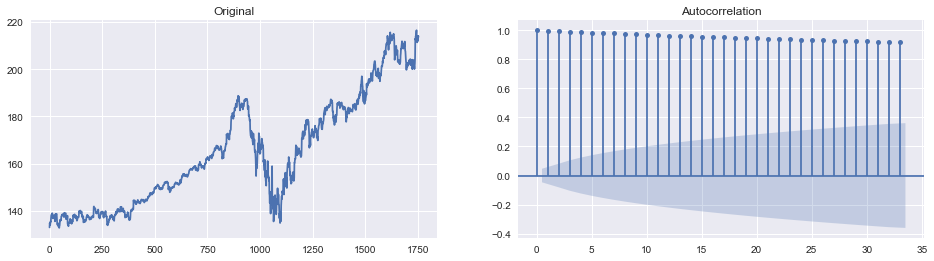

<IPython.core.display.Javascript object>

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(df.close)
ax1.set_title("Original")
# add ; at the end of the plot function so that the plot is not duplicated
plot_acf(df.close, ax=ax2)

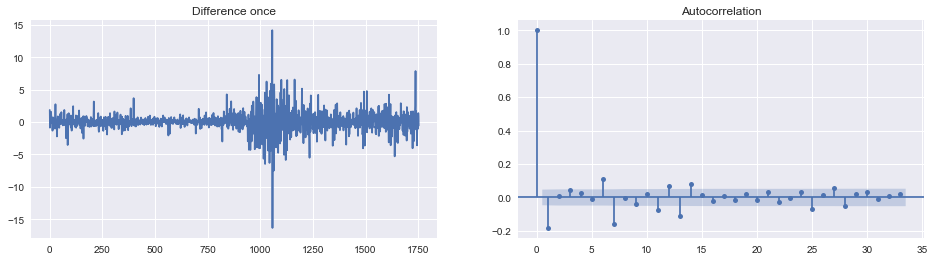

<IPython.core.display.Javascript object>

In [16]:
diff = df.close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference once")
plot_acf(diff, ax=ax2)

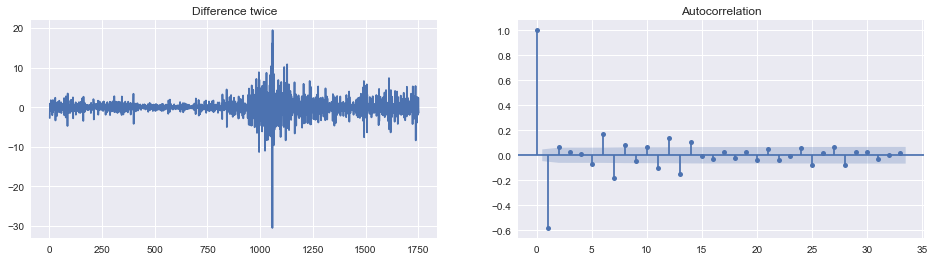

<IPython.core.display.Javascript object>

In [17]:
diff = df.close.diff().diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference twice")
plot_acf(diff, ax=ax2)

We can use the pmdarima package to get the number of differencing.

In [18]:
#!pipenv install --skip-lock pmdarima

from pmdarima.arima.utils import ndiffs

<IPython.core.display.Javascript object>

In [19]:
ndiffs(df.close, test="adf")

1

<IPython.core.display.Javascript object>

#### p

p is the order of the Auto Regressive (AR) term. It refers to the number of lags to be used as predictors. 

We can find out the required number of AR terms by inspecting the Partial Autocorrelation (PACF) plot.

The partial autocorrelation represents the correlation between the series and its lags. 

In [20]:
from statsmodels.graphics.tsaplots import plot_pacf

<IPython.core.display.Javascript object>

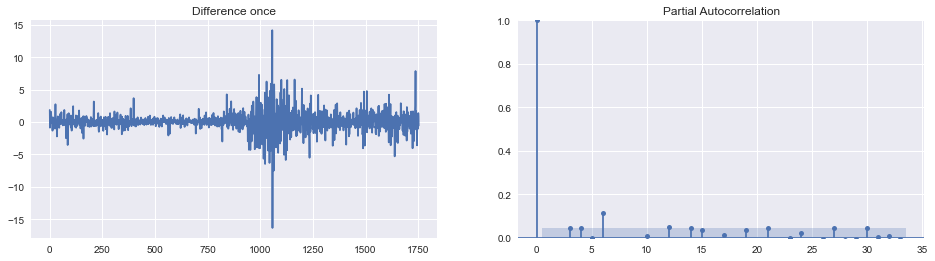

<IPython.core.display.Javascript object>

In [21]:
diff = df.close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference once")
ax2.set_ylim(0, 1)
plot_pacf(diff, ax=ax2)

We can observe that the PACF lag 6 is significant as it's above the significance line.

#### q

q is the order of the Moving Average (MA) term. It refers to the number of lagged forecast errors that should go into the ARIMA Model.

We can look at the ACF plot for the number of MA terms.

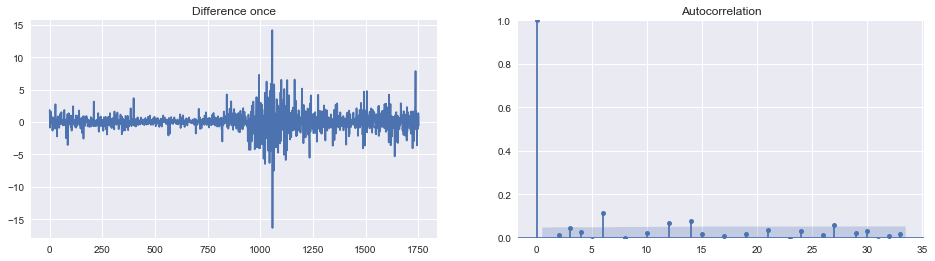

<IPython.core.display.Javascript object>

In [22]:
diff = df.close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference once")
ax2.set_ylim(0, 1)
plot_acf(diff, ax=ax2)

#### Fitting the ARIMA model

In [23]:
from statsmodels.tsa.arima_model import ARIMA

# ARIMA Model
model = ARIMA(df.close, order=(6, 1, 3))
result = model.fit(disp=0)

C:\Users\Jitender_bhatt\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


<IPython.core.display.Javascript object>

In [24]:
print(result.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                 1752
Model:                 ARIMA(6, 1, 3)   Log Likelihood               -2984.206
Method:                       css-mle   S.D. of innovations              1.329
Date:                Wed, 01 Jun 2022   AIC                           5990.412
Time:                        14:38:16   BIC                           6050.566
Sample:                             1   HQIC                          6012.647
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0461      0.031      1.480      0.139      -0.015       0.107
ar.L1.D.close    -0.6365      0.119     -5.346      0.000      -0.870      -0.403
ar.L2.D.close    -0.4278      0.134     

<IPython.core.display.Javascript object>

(array([2.23256914e-04, 0.00000000e+00, 1.11628457e-03, 7.14422125e-03,
        7.05491849e-02, 2.95368897e-01, 1.38419287e-02, 2.45582606e-03,
        2.23256914e-04, 2.23256914e-04]),
 array([-13.36180172, -10.80521234,  -8.24862296,  -5.69203358,
         -3.1354442 ,  -0.57885482,   1.97773456,   4.53432394,
          7.09091332,   9.6475027 ,  12.20409208]),
 <BarContainer object of 10 artists>)

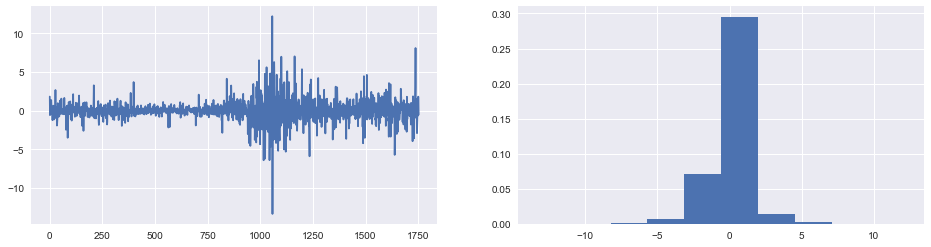

<IPython.core.display.Javascript object>

In [25]:
# Plot residual errors
residuals = pd.DataFrame(result.resid)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(residuals)
ax2.hist(residuals, density=True)


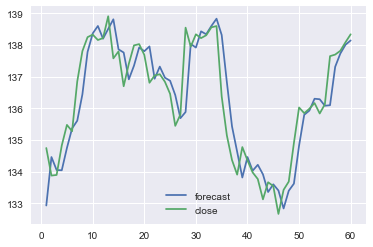

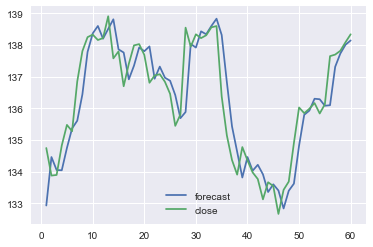

<IPython.core.display.Javascript object>

In [26]:
# Actual vs Fitted
result.plot_predict(
    start=1, end=60, dynamic=False,
)

### Train test split 

In [27]:
n = int(len(df) * 0.8)
train = df.close[:n]
test = df.close[n:]

<IPython.core.display.Javascript object>

In [28]:
print(len(train))
print(len(test))

1402
351


<IPython.core.display.Javascript object>

In [29]:
step = 30

model = ARIMA(train, order=(6, 1, 3))
result = model.fit(disp=0)

# Forecast
fc, se, conf = result.forecast(step)

C:\Users\Jitender_bhatt\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


<IPython.core.display.Javascript object>

In [30]:
fc

array([184.14010809, 184.16604636, 184.33262611, 184.2740894 ,
       184.35742683, 184.44528216, 184.47633691, 184.48711626,
       184.53956059, 184.56356054, 184.62423323, 184.65242717,
       184.68831041, 184.71499281, 184.76330247, 184.79525278,
       184.83818934, 184.86602963, 184.90686509, 184.94005946,
       184.98237773, 185.01421144, 185.05355828, 185.08630322,
       185.12659463, 185.16063643, 185.19959983, 185.23323745,
       185.27193425, 185.30662394])

<IPython.core.display.Javascript object>

In [31]:
se

array([1.31780876, 1.68237204, 1.97293452, 2.26924138, 2.56432524,
       2.83635238, 3.14675151, 3.36329135, 3.58591812, 3.79144687,
       4.00937601, 4.20052234, 4.39156872, 4.55918398, 4.7354987 ,
       4.89916881, 5.06463979, 5.2155298 , 5.36824292, 5.51198257,
       5.65826127, 5.79579847, 5.93353036, 6.06434632, 6.19616281,
       6.32250686, 6.44890663, 6.57021029, 6.69146224, 6.80877593])

<IPython.core.display.Javascript object>

In [33]:
conf

array([[181.55725038, 186.7229658 ],
       [180.86865775, 187.46343496],
       [180.46574551, 188.19950671],
       [179.82645803, 188.72172077],
       [179.33144172, 189.38341194],
       [178.88613365, 190.00443067],
       [178.30881728, 190.64385654],
       [177.89518634, 191.07904619],
       [177.51129022, 191.56783096],
       [177.13246121, 191.99465986],
       [176.76600065, 192.4824658 ],
       [176.41955466, 192.88529968],
       [176.08099388, 193.29562694],
       [175.7791564 , 193.65082922],
       [175.48189557, 194.04470938],
       [175.19305836, 194.39744719],
       [174.91167776, 194.76470092],
       [174.64377907, 195.0882802 ],
       [174.3853023 , 195.42842787],
       [174.13677214, 195.74334678],
       [173.89238943, 196.07236604],
       [173.65465519, 196.37376769],
       [173.42405249, 196.68306408],
       [173.20040285, 196.9722036 ],
       [172.98233869, 197.27085058],
       [172.76875069, 197.55252217],
       [172.55997509, 197.83922457],
 

<IPython.core.display.Javascript object>

In [34]:
fc = pd.Series(fc, index=test[:step].index)
lower = pd.Series(conf[:, 0], index=test[:step].index)
upper = pd.Series(conf[:, 1], index=test[:step].index)

<IPython.core.display.Javascript object>

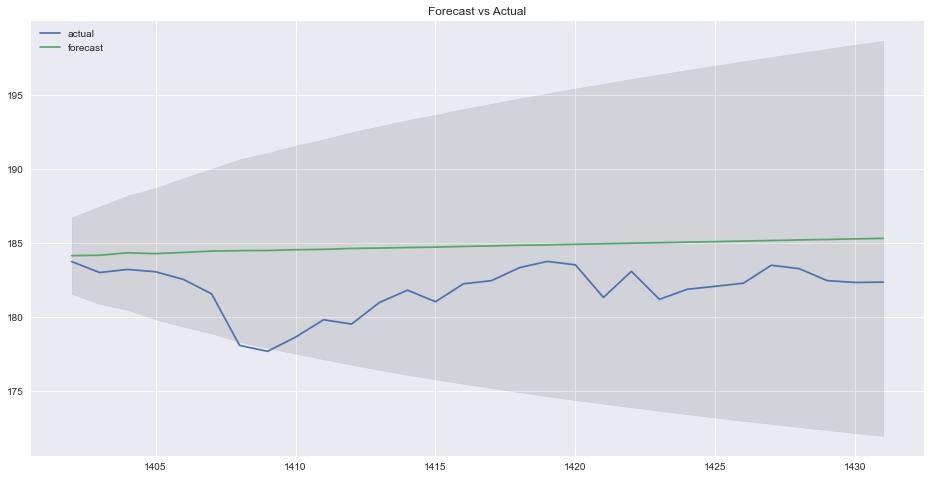

<IPython.core.display.Javascript object>

In [35]:
plt.figure(figsize=(16, 8))
plt.plot(test[:step], label="actual")
plt.plot(fc, label="forecast")
plt.fill_between(lower.index, lower, upper, color="k", alpha=0.1)
plt.title("Forecast vs Actual")
plt.legend(loc="upper left")

### Auto ARIMA

The pmdarima package provides an auto_arima method that uses a stepwise approach to search multiple combinations of p,d,q parameters and chooses the best model that has the least AIC.

In [36]:
from pmdarima.arima import auto_arima

<IPython.core.display.Javascript object>

In [37]:
model = auto_arima(
    df.close,
    start_p=1,
    start_q=1,
    test="adf",
    max_p=6,
    max_q=6,
    m=1,  # frequency of series
    d=None,  # determine 'd'
    seasonal=False,  # no seasonality
    trace=True,
    stepwise=True,
)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6040.470, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6096.252, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6039.073, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6039.508, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6096.214, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6040.138, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6041.460, Time=0.66 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=6039.893, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.676 seconds


<IPython.core.display.Javascript object>